<a href="https://colab.research.google.com/github/tempestormX/sc3021/blob/main/SC3021_FDAG_T13.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt

#**To what extent do greenhouse gas emissions and other human factors correlate with multi-dimensional weather patterns in each global region?**



## Hypothesis/analysis goal (Ask)


---



As the world becomes more industrialised, it has become evident that emissions of greenhouse gases into the atmosphere have been increasing. Weather patterns have been becoming more unpredictable and weather changes have become more drastic over time as well, as it is rather obvious that greenhouse gas emission affects the weather negatively. Atmospheric quality is dictated by a diverse array of greenhouse gases, each interacting uniquely with specific weather indicators such as temperature volatility, precipitation patterns, and atmospheric pressure. Therefore, we want to investigate the relationship between greenhouse gas emissions and weather patterns on a global scale to find out how these greenhouse gases affect the weather indicators in different regions globally.



## Data source identification and exploration (Prepare)

---



**Requirement analysis**: The greenhouse gases we are using for this analysis are Carbon Dioxide and Methane, as they are the main greenhouse gases. For each of them, we need data on emission by each country, emission per year and yearly changes in emission per country.

For weather patterns, our data should include different weather indicators for each country. Different weather indicators include precipitation, atmospheric pressure, wind speed, wind direction  and temperature. By merging these atmospheric and meteorological datasets, we can perform a multi-dimensional correlation analysis to identify how specific gases drive changes in regional climate stability and determine which factors have the most significant impact on global weather patterns



**List of considered sources:**
- [Earth Surface Temperature Data by Berkeley Earth](https://www.kaggle.com/datasets/berkeleyearth/climate-change-earth-surface-temperature-data?select=GlobalLandTemperaturesByCity.csv)
- [Daily Weather Data](https://www.kaggle.com/datasets/guillemservera/global-daily-climate-data/data?select=daily_weather.parquet)
- [Methane Emissions Data](https://ourworldindata.org/grapher/methane-emissions?tab=table&time=earliest..2024&country=OWID_ASI~OWID_NAM~OWID_SAM~OWID_EUR~USA~RUS)
- [Deforestation Data](https://ourworldindata.org/deforestation)
- [Carbon Dioxide Emissions Data](https://ourworldindata.org/co2-dataset-sources)


### DS1: Earth Surface Temperature Data by Berkeley Earth



In [ ]:
!mkdir /content/berkeley-temp
!curl -L -o /content/berkeley-temp.zip\
  https://www.kaggle.com/api/v1/datasets/download/berkeleyearth/climate-change-earth-surface-temperature-data
!unzip /content/berkeley-temp.zip -d /content/berkeley-temp/
!rm /content/berkeley-temp.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 84.7M  100 84.7M    0     0  80.7M      0  0:00:01  0:00:01 --:--:--  124M
Archive:  /content/berkeley-temp.zip
  inflating: /content/berkeley-temp/GlobalLandTemperaturesByCity.csv  
  inflating: /content/berkeley-temp/GlobalLandTemperaturesByCountry.csv  
  inflating: /content/berkeley-temp/GlobalLandTemperaturesByMajorCity.csv  
  inflating: /content/berkeley-temp/GlobalLandTemperaturesByState.csv  
  inflating: /content/berkeley-temp/GlobalTemperatures.csv  


In [ ]:
data_path = "/content/berkeley-temp/"
temp_by_city = pd.read_csv(data_path + "GlobalLandTemperaturesByCity.csv")
temp_by_city['dt'] = pd.to_datetime(temp_by_city['dt'])
print(temp_by_city.head())

          dt  AverageTemperature  AverageTemperatureUncertainty   City  \
0 1743-11-01               6.068                          1.737  Århus   
1 1743-12-01                 NaN                            NaN  Århus   
2 1744-01-01                 NaN                            NaN  Århus   
3 1744-02-01                 NaN                            NaN  Århus   
4 1744-03-01                 NaN                            NaN  Århus   

   Country Latitude Longitude  
0  Denmark   57.05N    10.33E  
1  Denmark   57.05N    10.33E  
2  Denmark   57.05N    10.33E  
3  Denmark   57.05N    10.33E  
4  Denmark   57.05N    10.33E  


In [ ]:
temp_by_city.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8599212 entries, 0 to 8599211
Data columns (total 7 columns):
 #   Column                         Dtype         
---  ------                         -----         
 0   dt                             datetime64[ns]
 1   AverageTemperature             float64       
 2   AverageTemperatureUncertainty  float64       
 3   City                           object        
 4   Country                        object        
 5   Latitude                       object        
 6   Longitude                      object        
dtypes: datetime64[ns](1), float64(2), object(4)
memory usage: 459.2+ MB


In [ ]:
temp_by_city.describe()

,dt,AverageTemperature,AverageTemperatureUncertainty
count,8599212,8.235082e+06,8.235082e+06
mean,1907-10-21 07:06:00.828411904,1.672743e+01,1.028575e+00
min,1743-11-01 00:00:00,-4.270400e+01,3.400000e-02
25%,1860-06-01 00:00:00,1.029900e+01,3.370000e-01
50%,1911-09-01 00:00:00,1.883100e+01,5.910000e-01
75%,1962-09-01 00:00:00,2.521000e+01,1.349000e+00
max,2013-09-01 00:00:00,3.965100e+01,1.539600e+01
std,NaN,1.035344e+01,1.129733e+00


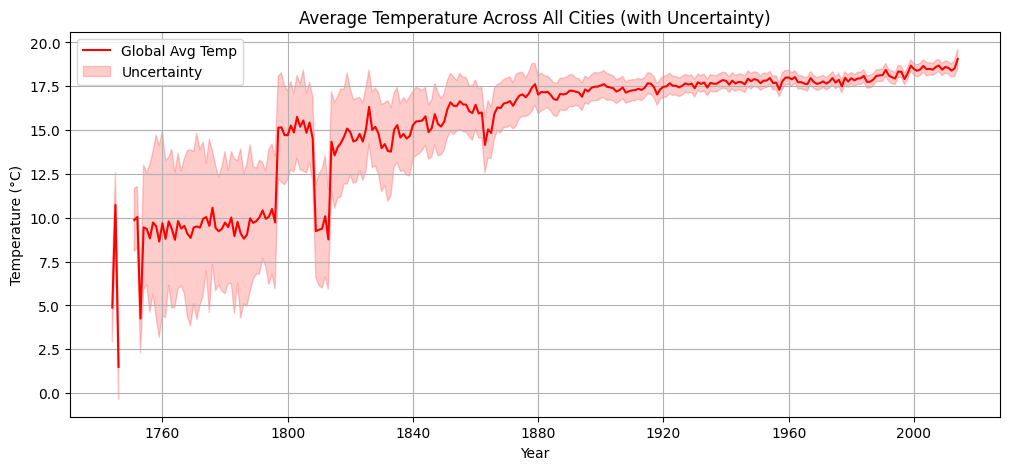

In [ ]:
# Compute mean for numeric columns
numeric_cols = ['AverageTemperature', 'AverageTemperatureUncertainty']
df_yearly = temp_by_city[numeric_cols + ['dt']].resample('YE', on='dt').mean()

# Plot yearly average temperature with uncertainty
plt.figure(figsize=(12,5))
plt.plot(df_yearly.index, df_yearly['AverageTemperature'], color='red', label='Global Avg Temp')
plt.fill_between(
    df_yearly.index,
    df_yearly['AverageTemperature'] - df_yearly['AverageTemperatureUncertainty'],
    df_yearly['AverageTemperature'] + df_yearly['AverageTemperatureUncertainty'],
    color='red', alpha=0.2, label='Uncertainty'
)
plt.xlabel('Year')
plt.ylabel('Temperature (°C)')
plt.title('Average Temperature Across All Cities (with Uncertainty)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Show top 20 hottest cities
city_avg = temp_by_city.groupby('City')[numeric_cols].mean().sort_values('AverageTemperature', ascending=False)
print(city_avg.head(20))

              AverageTemperature  AverageTemperatureUncertainty
City                                                           
Jibuti                 29.152790                       0.923249
Umm Durman             29.081291                       0.890629
Khartoum               29.081291                       0.890629
Niamey                 29.062560                       0.779363
Kassala                28.938776                       0.860550
Mopti                  28.784449                       0.890024
Rabak                  28.598226                       0.806627
Kusti                  28.598226                       0.806627
Tiruvottiyur           28.417858                       0.999483
Madras                 28.417858                       0.999483
Avadi                  28.417858                       0.999483
Pallavaram             28.417858                       0.999483
Tirupati               28.417858                       0.999483
Alandur                28.417858        

Chart 1a: 

In [ ]:
INPUT_PATH = './cleaning/datasets/EarthSurfaceTemp.csv'
OUTPUT_PATH = './cleaning/datasets/EarthSurfaceTemp_Cleaned.csv'

# Temperature columns per source type
GLOBAL_TEMP_COLS = [
    'LandAverageTemperature', 'LandAverageTemperatureUncertainty',
    'LandMaxTemperature', 'LandMaxTemperatureUncertainty',
    'LandMinTemperature', 'LandMinTemperatureUncertainty',
    'LandAndOceanAverageTemperature', 'LandAndOceanAverageTemperatureUncertainty',
]
REGIONAL_TEMP_COLS = ['AverageTemperature', 'AverageTemperatureUncertainty']

# Group keys by source for geographic grouping
GROUP_KEYS = {
    'GlobalTemperatures': [],                # no geographic grouping
    'ByCountry': ['Country'],
    'ByState': ['Country', 'State'],
    'ByCity': ['City', 'Country'],
}
# STEP 1: LOAD DATA

print("=" * 70)
print("LOADING DATA")
print("=" * 70)

df = pd.read_csv(INPUT_PATH, low_memory=False)
df['dt'] = pd.to_datetime(df['dt'])
df['Year'] = df['dt'].dt.year

print(f"Loaded {len(df):,} rows, {len(df.columns)} columns")
print(f"Sources: {df['Source'].value_counts().to_dict()}")
print(f"Date range: {df['dt'].min()} to {df['dt'].max()}")


# STEP 2: FILL MISSING TEMPERATURE DATA (5-YEAR WINDOW MEAN)

initial_missing = df.isnull().sum()
print("\nMissing values BEFORE cleaning (temperature columns only):")
for col in REGIONAL_TEMP_COLS + GLOBAL_TEMP_COLS:
    if initial_missing[col] > 0:
        total = df[col].notna().sum() + initial_missing[col]
        # Only count structural missing (within source)
        print(f"  {col}: {initial_missing[col]:,} missing")


def fill_missing_5yr_mean(group_df, temp_cols):
    """
    For each temperature column, fill NaN values with the mean of non-NaN
    values within a ±2-year window (5-year range) of the same group.
    Uses vectorized year-based grouping for performance.
    """
    group_df = group_df.copy()
    for col in temp_cols:
        if group_df[col].isnull().any():
            # Build a year→mean lookup from available data
            yearly_mean = group_df.groupby('Year')[col].mean()

            missing_mask = group_df[col].isnull()
            missing_years = group_df.loc[missing_mask, 'Year']

            for year in missing_years.unique():
                window_years = range(year - 2, year + 3)  # ±2 years
                window_means = yearly_mean.reindex(window_years).dropna()
                if len(window_means) > 0:
                    fill_val = window_means.mean()
                    year_and_missing = missing_mask & (group_df['Year'] == year)
                    group_df.loc[year_and_missing, col] = fill_val
    return group_df


# Process each source separately with appropriate grouping
filled_parts = []
for source, keys in GROUP_KEYS.items():
    subset = df[df['Source'] == source].copy()
    if len(subset) == 0:
        continue

    # Choose which temp columns to fill based on source
    if source == 'GlobalTemperatures':
        cols_to_fill = GLOBAL_TEMP_COLS
    else:
        cols_to_fill = REGIONAL_TEMP_COLS

    print(f"\n  Processing {source} ({len(subset):,} rows)...")
    before = subset[cols_to_fill].isnull().sum().sum()

    if keys:
        # Group by geographic keys, fill within each group
        subset = subset.groupby(keys, group_keys=False).apply(
            lambda g: fill_missing_5yr_mean(g, cols_to_fill),
            include_groups=False
        )
        # Re-add the group key columns that were excluded
        for key in keys:
            if key not in subset.columns:
                subset = subset.join(
                    df.loc[df['Source'] == source, key], how='left'
                )
    else:
        subset = fill_missing_5yr_mean(subset, cols_to_fill)

    after = subset[cols_to_fill].isnull().sum().sum()
    print(f"    Filled {before - after:,} missing values ({after:,} remaining)")
    filled_parts.append(subset)

df = pd.concat(filled_parts, ignore_index=True)

print("\n\nMissing values AFTER filling (temperature columns only):")
post_missing = df.isnull().sum()
for col in REGIONAL_TEMP_COLS + GLOBAL_TEMP_COLS:
    if post_missing[col] > 0:
        print(f"  {col}: {post_missing[col]:,} missing")



# STEP 3: REMOVE OUTLIERS (IQR METHOD)

rows_before = len(df)
outlier_mask = pd.Series(False, index=df.index)

for source, keys in GROUP_KEYS.items():
    subset_mask = df['Source'] == source
    if subset_mask.sum() == 0:
        continue

    # Primary temperature column for this source
    if source == 'GlobalTemperatures':
        temp_col = 'LandAverageTemperature'
    else:
        temp_col = 'AverageTemperature'

    subset = df.loc[subset_mask].copy()

    if keys:
        # Compute IQR within each geographic group
        grouped = subset.groupby(keys)[temp_col]
        Q1 = grouped.transform('quantile', 0.25)
        Q3 = grouped.transform('quantile', 0.75)
    else:
        Q1 = subset[temp_col].quantile(0.25)
        Q3 = subset[temp_col].quantile(0.75)

    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    # Identify outliers within the subset (preserves index alignment)
    is_outlier = ((subset[temp_col] < lower) | (subset[temp_col] > upper)) & subset[temp_col].notna()
    outlier_mask.loc[is_outlier.index] = outlier_mask.loc[is_outlier.index] | is_outlier

    n_outliers = is_outlier.sum()
    print(f"  {source}: {n_outliers:,} outliers detected in '{temp_col}'")

print(f"\n  Total outliers removed: {outlier_mask.sum():,} / {rows_before:,} rows")
df = df[~outlier_mask].reset_index(drop=True)
print(f"  Rows remaining: {len(df):,}")


# STEP 4: CLEAN UP & SAVE

print("\n" + "=" * 70)
print("STEP 4: SAVING CLEANED DATA")
print("=" * 70)

# Drop the helper Year column
df.drop(columns=['Year'], inplace=True)

df.to_csv(OUTPUT_PATH, index=False)
print(f"Saved cleaned dataset to: {OUTPUT_PATH}")
print(f"Final shape: {df.shape[0]:,} rows × {df.shape[1]} columns")


# BRIEF ANALYSIS OF THE DATA

# Re-derive Year for analysis
df['Year'] = pd.to_datetime(df['dt']).dt.year

# --- Global temperature trends ---
global_df = df[df['Source'] == 'GlobalTemperatures'].copy()
if len(global_df) > 0:
    decade_avg = global_df.groupby((global_df['Year'] // 10) * 10)['LandAverageTemperature'].mean()
    print("\n1) Global Land Average Temperature by Decade (°C):")
    for decade, temp in decade_avg.items():
        print(f"     {decade}s: {temp:.2f}°C")

    early = global_df[global_df['Year'] <= 1800]['LandAverageTemperature'].mean()
    recent = global_df[global_df['Year'] >= 2000]['LandAverageTemperature'].mean()
    print(f"\n   Warming trend: {early:.2f}°C (≤1800) → {recent:.2f}°C (≥2000)  "
          f"[+{recent - early:.2f}°C]")

# --- Regional temperature summary ---
regional_df = df[df['Source'].isin(['ByCountry', 'ByState', 'ByCity'])].copy()
if len(regional_df) > 0:
    print("\n2) Regional Temperature Summary (AverageTemperature, °C):")
    for src in ['ByCountry', 'ByState', 'ByCity']:
        s = regional_df[regional_df['Source'] == src]['AverageTemperature']
        if len(s) > 0:
            print(f"     {src:12s}: mean={s.mean():.2f}, std={s.std():.2f}, "
                  f"min={s.min():.2f}, max={s.max():.2f}")

# --- Hottest / coldest countries ---
country_df = df[df['Source'] == 'ByCountry'].copy()
if len(country_df) > 0:
    country_means = country_df.groupby('Country')['AverageTemperature'].mean().dropna()
    top5_hot = country_means.nlargest(5)
    top5_cold = country_means.nsmallest(5)
    print("\n3) Top 5 Hottest Countries (avg °C):")
    for c, t in top5_hot.items():
        print(f"     {c}: {t:.2f}°C")
    print("\n   Top 5 Coldest Countries (avg °C):")
    for c, t in top5_cold.items():
        print(f"     {c}: {t:.2f}°C")

# --- Warming acceleration ---
if len(global_df) > 0:
    century_avg = global_df.groupby((global_df['Year'] // 100) * 100)['LandAverageTemperature'].mean()
    print("\n4) Century-level Averages (°C):")
    for century, temp in century_avg.items():
        print(f"     {century}s: {temp:.2f}°C")

# --- Data quality ---
print("\n5) Data Quality Summary:")
print(f"     Total records after cleaning: {len(df):,}")
remaining_na = df[REGIONAL_TEMP_COLS + GLOBAL_TEMP_COLS].isnull().sum()
remaining_na = remaining_na[remaining_na > 0]
if len(remaining_na) > 0:
    print("     Remaining NaN (structural - column not applicable to source):")
    for col, count in remaining_na.items():
        print(f"       {col}: {count:,}")
else:
    print("     No missing temperature values remain.")



# ---- Chart 1: Regional Temperature Comparison Over Time ----
# Map every country to a world region
REGION_MAP = {
    # ---- AFRICA ----
    'Algeria': 'Africa', 'Angola': 'Africa', 'Benin': 'Africa',
    'Botswana': 'Africa', 'Burkina Faso': 'Africa', 'Burundi': 'Africa',
    'Cameroon': 'Africa', 'Cape Verde': 'Africa',
    'Central African Republic': 'Africa', 'Chad': 'Africa', 'Comoros': 'Africa',
    'Congo': 'Africa', 'Congo (Democratic Republic Of The)': 'Africa',
    "Côte D'Ivoire": 'Africa', 'Djibouti': 'Africa', 'Egypt': 'Africa',
    'Equatorial Guinea': 'Africa', 'Eritrea': 'Africa', 'Ethiopia': 'Africa',
    'Gabon': 'Africa', 'Gambia': 'Africa', 'Ghana': 'Africa',
    'Guinea': 'Africa', 'Guinea Bissau': 'Africa', 'Kenya': 'Africa',
    'Lesotho': 'Africa', 'Liberia': 'Africa', 'Libya': 'Africa',
    'Madagascar': 'Africa', 'Malawi': 'Africa', 'Mali': 'Africa',
    'Mauritania': 'Africa', 'Mauritius': 'Africa', 'Mayotte': 'Africa',
    'Morocco': 'Africa', 'Mozambique': 'Africa', 'Namibia': 'Africa',
    'Niger': 'Africa', 'Nigeria': 'Africa', 'Reunion': 'Africa',
    'Rwanda': 'Africa', 'Sao Tome And Principe': 'Africa',
    'Senegal': 'Africa', 'Seychelles': 'Africa', 'Sierra Leone': 'Africa',
    'Somalia': 'Africa', 'South Africa': 'Africa', 'Sudan': 'Africa',
    'Swaziland': 'Africa', 'Tanzania': 'Africa', 'Togo': 'Africa',
    'Tunisia': 'Africa', 'Uganda': 'Africa', 'Western Sahara': 'Africa',
    'Zambia': 'Africa', 'Zimbabwe': 'Africa',
    # ---- ASIA ----
    'Afghanistan': 'Asia', 'Armenia': 'Asia', 'Azerbaijan': 'Asia',
    'Bangladesh': 'Asia', 'Bhutan': 'Asia', 'Burma': 'Asia',
    'Cambodia': 'Asia', 'China': 'Asia', 'Georgia': 'Asia',
    'Hong Kong': 'Asia', 'India': 'Asia', 'Indonesia': 'Asia',
    'Japan': 'Asia', 'Kazakhstan': 'Asia', 'Kyrgyzstan': 'Asia',
    'Laos': 'Asia', 'Macau': 'Asia', 'Malaysia': 'Asia',
    'Mongolia': 'Asia', 'Nepal': 'Asia', 'North Korea': 'Asia',
    'Pakistan': 'Asia', 'Philippines': 'Asia', 'Singapore': 'Asia',
    'South Korea': 'Asia', 'Sri Lanka': 'Asia', 'Taiwan': 'Asia',
    'Tajikistan': 'Asia', 'Thailand': 'Asia', 'Timor Leste': 'Asia',
    'Turkmenistan': 'Asia', 'Uzbekistan': 'Asia', 'Vietnam': 'Asia',
    # ---- EUROPE ----
    'Albania': 'Europe', 'Andorra': 'Europe', 'Austria': 'Europe',
    'Belarus': 'Europe', 'Belgium': 'Europe',
    'Bosnia And Herzegovina': 'Europe', 'Bulgaria': 'Europe',
    'Croatia': 'Europe', 'Cyprus': 'Europe', 'Czech Republic': 'Europe',
    'Denmark (Europe)': 'Europe', 'Estonia': 'Europe',
    'Faroe Islands': 'Europe', 'Finland': 'Europe',
    'France (Europe)': 'Europe', 'Germany': 'Europe', 'Greece': 'Europe',
    'Guernsey': 'Europe', 'Hungary': 'Europe', 'Iceland': 'Europe',
    'Ireland': 'Europe', 'Isle Of Man': 'Europe', 'Italy': 'Europe',
    'Jersey': 'Europe', 'Latvia': 'Europe', 'Liechtenstein': 'Europe',
    'Lithuania': 'Europe', 'Luxembourg': 'Europe', 'Macedonia': 'Europe',
    'Malta': 'Europe', 'Moldova': 'Europe', 'Monaco': 'Europe',
    'Montenegro': 'Europe', 'Netherlands (Europe)': 'Europe',
    'Norway': 'Europe', 'Poland': 'Europe', 'Portugal': 'Europe',
    'Romania': 'Europe', 'San Marino': 'Europe', 'Serbia': 'Europe',
    'Slovakia': 'Europe', 'Slovenia': 'Europe', 'Spain': 'Europe',
    'Sweden': 'Europe', 'Switzerland': 'Europe',
    'United Kingdom (Europe)': 'Europe', 'Åland': 'Europe',
    'Svalbard And Jan Mayen': 'Europe', 'France': 'Europe',
    'Denmark': 'Europe', 'Netherlands': 'Europe', 'United Kingdom': 'Europe',
    'Ukraine': 'Europe',
    # ---- MIDDLE EAST ----
    'Bahrain': 'Middle East', 'Gaza Strip': 'Middle East', 'Iran': 'Middle East',
    'Iraq': 'Middle East', 'Israel': 'Middle East', 'Jordan': 'Middle East',
    'Kuwait': 'Middle East', 'Lebanon': 'Middle East', 'Oman': 'Middle East',
    'Palestina': 'Middle East', 'Qatar': 'Middle East',
    'Saudi Arabia': 'Middle East', 'Syria': 'Middle East',
    'Turkey': 'Middle East', 'United Arab Emirates': 'Middle East',
    'Yemen': 'Middle East',
    # ---- NORTH AMERICA ----
    'Anguilla': 'North America', 'Antigua And Barbuda': 'North America',
    'Bahamas': 'North America', 'Barbados': 'North America',
    'Belize': 'North America', 'British Virgin Islands': 'North America',
    'Canada': 'North America', 'Cayman Islands': 'North America',
    'Costa Rica': 'North America', 'Cuba': 'North America',
    'Dominica': 'North America', 'Dominican Republic': 'North America',
    'El Salvador': 'North America', 'Grenada': 'North America',
    'Guadeloupe': 'North America', 'Guatemala': 'North America',
    'Haiti': 'North America', 'Honduras': 'North America',
    'Jamaica': 'North America', 'Martinique': 'North America',
    'Mexico': 'North America', 'Montserrat': 'North America',
    'Nicaragua': 'North America', 'Panama': 'North America',
    'Puerto Rico': 'North America', 'Saint Barthélemy': 'North America',
    'Saint Kitts And Nevis': 'North America',
    'Saint Lucia': 'North America', 'Saint Martin': 'North America',
    'Saint Vincent And The Grenadines': 'North America',
    'Sint Maarten': 'North America',
    'Trinidad And Tobago': 'North America',
    'Turks And Caicas Islands': 'North America',
    'United States': 'North America', 'Virgin Islands': 'North America',
    'Aruba': 'North America', 'Bonaire, Saint Eustatius And Saba': 'North America',
    'Curaçao': 'North America',
    'Saint Pierre And Miquelon': 'North America',
    # ---- SOUTH AMERICA ----
    'Argentina': 'South America', 'Bolivia': 'South America',
    'Brazil': 'South America', 'Chile': 'South America',
    'Colombia': 'South America', 'Ecuador': 'South America',
    'Falkland Islands (Islas Malvinas)': 'South America',
    'French Guiana': 'South America', 'Guyana': 'South America',
    'Paraguay': 'South America', 'Peru': 'South America',
    'South Georgia And The South Sandwich Isla': 'South America',
    'Suriname': 'South America', 'Uruguay': 'South America',
    'Venezuela': 'South America',
    # ---- OCEANIA ----
    'American Samoa': 'Oceania', 'Australia': 'Oceania',
    'Christmas Island': 'Oceania',
    'Federated States Of Micronesia': 'Oceania', 'Fiji': 'Oceania',
    'French Polynesia': 'Oceania',
    'French Southern And Antarctic Lands': 'Oceania',
    'Guam': 'Oceania',
    'Heard Island And Mcdonald Islands': 'Oceania',
    'Kiribati': 'Oceania', 'New Caledonia': 'Oceania',
    'New Zealand': 'Oceania', 'Niue': 'Oceania',
    'Northern Mariana Islands': 'Oceania', 'Palau': 'Oceania',
    'Papua New Guinea': 'Oceania', 'Samoa': 'Oceania',
    'Solomon Islands': 'Oceania', 'Tonga': 'Oceania',
    'Baker Island': 'Oceania', 'Kingman Reef': 'Oceania',
    'Palmyra Atoll': 'Oceania',
    # ---- RUSSIA (own category — spans Europe & Asia) ----
    'Russia': 'Russia',
    # ---- POLAR ----
    'Antarctica': 'Polar', 'Greenland': 'Polar',
}

# Continent-level aggregate entries to exclude (already aggregated in original data)
SKIP_ENTRIES = {'Africa', 'Asia', 'Europe', 'North America', 'Oceania', 'South America'}

print('\n  Building regional comparison...')
region_df = country_df.copy()
region_df = region_df[~region_df['Country'].isin(SKIP_ENTRIES)]
region_df['Region'] = region_df['Country'].map(REGION_MAP)

unmapped = region_df[region_df['Region'].isna()]['Country'].unique()
if len(unmapped) > 0:
    print(f'    Warning: {len(unmapped)} unmapped countries excluded: {list(unmapped)}')
region_df = region_df.dropna(subset=['Region', 'AverageTemperature'])

# -- Chart 6a: Average Temperature by Region by Decade (grouped bar) --
region_df['Decade'] = (region_df['Year'] // 10) * 10

# Only use decades with decent data coverage (1850+)
region_df_plot = region_df[region_df['Decade'] >= 1850]
decade_region = region_df_plot.groupby(['Decade', 'Region'])['AverageTemperature'].mean().reset_index()

regions_order = ['Africa', 'Asia', 'Europe', 'Middle East', 'North America',
                 'South America', 'Oceania', 'Russia', 'Polar']
region_colors = {
    'Africa': '#e67e22', 'Asia': '#e74c3c', 'Europe': '#3498db',
    'Middle East': '#f1c40f', 'North America': '#2ecc71',
    'South America': '#1abc9c', 'Oceania': '#9b59b6',
    'Russia': '#95a5a6', 'Polar': '#ecf0f1',
}
present_regions = [r for r in regions_order if r in decade_region['Region'].unique()]

fig, ax = plt.subplots(figsize=(20, 8))
decades = sorted(decade_region['Decade'].unique())
n_regions = len(present_regions)
bar_width = 0.8 / n_regions
x = np.arange(len(decades))

for i, region in enumerate(present_regions):
    data = decade_region[decade_region['Region'] == region].set_index('Decade')['AverageTemperature']
    vals = [data.get(d, np.nan) for d in decades]
    ax.bar(x + i * bar_width, vals, bar_width, label=region,
           color=region_colors[region], edgecolor='white', alpha=0.85)

ax.set_xticks(x + bar_width * (n_regions - 1) / 2)
ax.set_xticklabels([f'{d}s' for d in decades], rotation=45, ha='right')
ax.set_xlabel('Decade', fontsize=12)
ax.set_ylabel('Avg Surface Temperature (°C)', fontsize=12)
ax.set_title('Earth Surface Temperature by World Region & Decade (1850–2010s)',
             fontsize=15, fontweight='bold')
ax.legend(loc='upper left', ncol=3, fontsize=9, framealpha=0.9)
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
fig.savefig(f'{CHART_DIR}/chart1a_regional_decade_comparison.png', dpi=150)
plt.close(fig)

# -- Chart 1b: Temperature Change Per Region (Recent vs Early baseline) --
early_period = region_df[(region_df['Year'] >= 1850) & (region_df['Year'] <= 1900)]
recent_period = region_df[(region_df['Year'] >= 2000)]
early_means = early_period.groupby('Region')['AverageTemperature'].mean()
recent_means = recent_period.groupby('Region')['AverageTemperature'].mean()
change = (recent_means - early_means).reindex(present_regions).dropna().sort_values()

fig, ax = plt.subplots(figsize=(10, 7))
colors_bar = [COLOR_WARM if v > 0 else COLOR_COLD for v in change.values]
bars = ax.barh(change.index, change.values, color=colors_bar, edgecolor='white', height=0.6)
for bar, val in zip(bars, change.values):
    ax.text(val + 0.05 if val > 0 else val - 0.05, bar.get_y() + bar.get_height() / 2,
            f'{val:+.2f}°C', va='center', ha='left' if val > 0 else 'right',
            fontsize=11, fontweight='bold')
ax.axvline(x=0, color='black', linewidth=0.8)
ax.set_xlabel('Temperature Change (°C)', fontsize=12)
ax.set_title('Temperature Change by Region: 1850-1900 Baseline vs 2000+',
             fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
fig.savefig(f'{CHART_DIR}/chart1b_regional_warming_change.png', dpi=150)
plt.close(fig)

# -- Chart 1c: Century-level Comparison Across Regions (grouped bar) --
region_df['Century'] = (region_df['Year'] // 100) * 100
century_region = region_df.groupby(['Century', 'Region'])['AverageTemperature'].mean().reset_index()
centuries = sorted(century_region['Century'].unique())

fig, ax = plt.subplots(figsize=(14, 7))
n_cents = len(centuries)
bar_width_c = 0.8 / n_cents
x_r = np.arange(len(present_regions))

century_palette = sns.color_palette('YlOrRd', n_cents)
for i, cent in enumerate(centuries):
    data = century_region[century_region['Century'] == cent].set_index('Region')['AverageTemperature']
    vals = [data.get(r, np.nan) for r in present_regions]
    ax.bar(x_r + i * bar_width_c, vals, bar_width_c, label=f'{cent}s',
           color=century_palette[i], edgecolor='white')

ax.set_xticks(x_r + bar_width_c * (n_cents - 1) / 2)
ax.set_xticklabels(present_regions, rotation=30, ha='right')
ax.set_ylabel('Avg Surface Temperature (°C)', fontsize=12)
ax.set_title('Regional Temperature by Century — All Regions Compared',
             fontsize=15, fontweight='bold')
ax.legend(title='Century', fontsize=10, title_fontsize=11)
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
fig.savefig(f'{CHART_DIR}/chart1c_regional_century_comparison.png', dpi=150)
plt.close(fig)


### DS2: Daily Weather Data

In [ ]:
!mkdir /content/weather
!curl -L -o /content/weather.zip\
  https://www.kaggle.com/api/v1/datasets/download/guillemservera/global-daily-climate-data
!unzip /content/weather.zip -d /content/weather/
!rm /content/weather.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  212M  100  212M    0     0   145M      0  0:00:01  0:00:01 --:--:--  205M
Archive:  /content/weather.zip
  inflating: /content/weather/cities.csv  
  inflating: /content/weather/countries.csv  
  inflating: /content/weather/daily_weather.parquet  


In [ ]:
data_path = "/content/weather/"
weather = pd.read_parquet(data_path + "daily_weather.parquet")
# weather['dt'] = pd.to_datetime(weather['dt'])
print(weather.head())

  station_id city_name       date  season  avg_temp_c  min_temp_c  max_temp_c  \
0      41515  Asadabad 1957-07-01  Summer        27.0        21.1        35.6   
1      41515  Asadabad 1957-07-02  Summer        22.8        18.9        32.2   
2      41515  Asadabad 1957-07-03  Summer        24.3        16.7        35.6   
3      41515  Asadabad 1957-07-04  Summer        26.6        16.1        37.8   
4      41515  Asadabad 1957-07-05  Summer        30.8        20.0        41.7   

   precipitation_mm  snow_depth_mm  avg_wind_dir_deg  avg_wind_speed_kmh  \
0               0.0            NaN               NaN                 NaN   
1               0.0            NaN               NaN                 NaN   
2               1.0            NaN               NaN                 NaN   
3               4.1            NaN               NaN                 NaN   
4               0.0            NaN               NaN                 NaN   

   peak_wind_gust_kmh  avg_sea_level_pres_hpa  sunshine_

In [ ]:
cities = pd.read_csv(data_path + "cities.csv")
print(cities.head())

  station_id   city_name      country       state iso2 iso3   latitude  \
0      41515    Asadabad  Afghanistan       Kunar   AF  AFG  34.866000   
1      38954    Fayzabad  Afghanistan  Badakhshan   AF  AFG  37.129761   
2      41560   Jalalabad  Afghanistan   Nangarhar   AF  AFG  34.441527   
3      38947      Kunduz  Afghanistan      Kunduz   AF  AFG  36.727951   
4      38987  Qala i Naw  Afghanistan     Badghis   AF  AFG  34.983000   

   longitude  
0  71.150005  
1  70.579247  
2  70.436103  
3  68.872530  
4  63.133300  


In [ ]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27635763 entries, 0 to 24220
Data columns (total 14 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   station_id              category      
 1   city_name               category      
 2   date                    datetime64[us]
 3   season                  category      
 4   avg_temp_c              float64       
 5   min_temp_c              float64       
 6   max_temp_c              float64       
 7   precipitation_mm        float64       
 8   snow_depth_mm           float64       
 9   avg_wind_dir_deg        float64       
 10  avg_wind_speed_kmh      float64       
 11  peak_wind_gust_kmh      float64       
 12  avg_sea_level_pres_hpa  float64       
 13  sunshine_total_min      float64       
dtypes: category(3), datetime64[us](1), float64(10)
memory usage: 2.6 GB


In [ ]:
weather.describe()

,date,avg_temp_c,min_temp_c,max_temp_c,precipitation_mm,snow_depth_mm,avg_wind_dir_deg,avg_wind_speed_kmh,peak_wind_gust_kmh,avg_sea_level_pres_hpa,sunshine_total_min
count,27635763,2.140486e+07,2.191753e+07,2.209642e+07,2.099326e+07,3.427148e+06,3.452568e+06,5.285468e+06,1.121486e+06,4.017157e+06,1.021461e+06
mean,1982-11-29 10:03:03.195926,1.572252e+01,9.948255e+00,2.015998e+01,2.740569e+00,7.996231e+01,1.820979e+02,1.240827e+01,3.857887e+01,1.015032e+03,3.504399e+02
min,1750-02-01 00:00:00,-7.000000e+01,-9.900000e+01,-9.900000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,8.610000e+02,0.000000e+00
25%,1965-05-06 00:00:00,8.300000e+00,2.800000e+00,1.200000e+01,0.000000e+00,0.000000e+00,8.600000e+01,7.500000e+00,2.630000e+01,1.010300e+03,5.400000e+01
50%,1988-02-04 00:00:00,1.790000e+01,1.110000e+01,2.230000e+01,0.000000e+00,0.000000e+00,1.910000e+02,1.090000e+01,3.530000e+01,1.014700e+03,3.460000e+02
75%,2007-01-25 00:00:00,2.570000e+01,1.920000e+01,3.020000e+01,1.000000e+00,2.000000e+01,2.710000e+02,1.570000e+01,4.640000e+01,1.019800e+03,5.940000e+02
max,2023-09-05 00:00:00,5.040000e+01,6.420000e+01,9.700000e+01,1.000000e+03,9.710000e+03,3.600000e+02,1.763000e+02,4.392000e+02,5.852700e+03,1.302000e+03
std,NaN,1.202205e+01,1.155787e+01,1.249478e+01,9.791887e+00,3.500756e+02,1.051996e+02,7.054249e+00,2.010951e+01,8.520450e+00,2.815142e+02


In [ ]:
cities = cities.with_columns(
    pl.col("station_id").cast(pl.Categorical)
)
merged = weather.join(cities, on="station_id", how="left")
print(merged.head())


AttributeError: 'DataFrame' object has no attribute 'with_columns'

In [ ]:
merged_pd = merged.to_pandas()

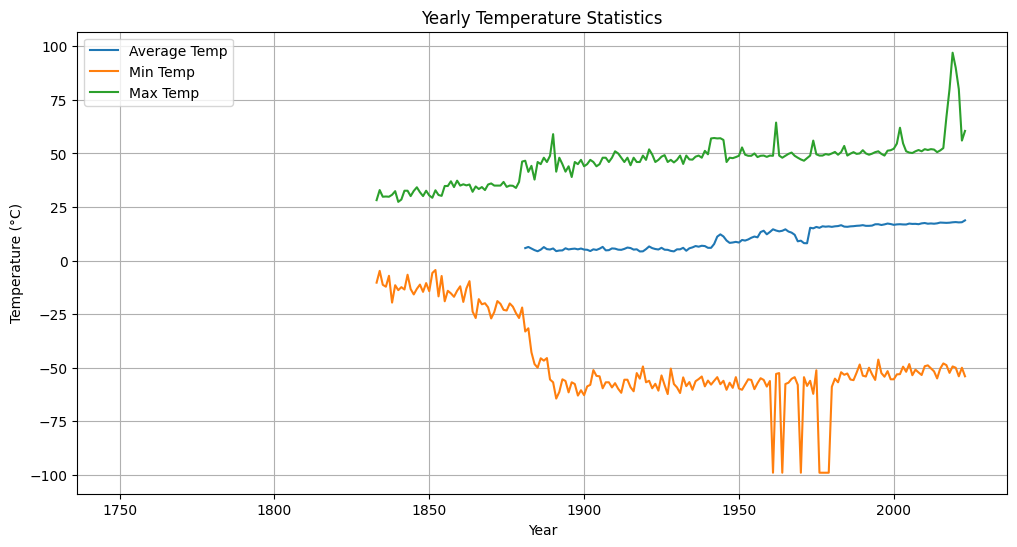

In [ ]:
df_yearly = weather.resample('YE', on='date').agg({
    'avg_temp_c': 'mean',
    'min_temp_c': 'min',
    'max_temp_c': 'max'
})

plt.figure(figsize=(12,6))
plt.plot(df_yearly.index.year, df_yearly['avg_temp_c'], label='Average Temp')
plt.plot(df_yearly.index.year, df_yearly['min_temp_c'], label='Min Temp')
plt.plot(df_yearly.index.year, df_yearly['max_temp_c'], label='Max Temp')

plt.title('Yearly Temperature Statistics')
plt.xlabel('Year')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True)
plt.show()

### DS3: Community Emissions Data System (CEDS)

In [ ]:
!curl -L -o /content/CEDS_v_2025_03_18_aggregate.zip\
  https://zenodo.org/records/15059443/files/CEDS_v_2025_03_18_aggregate.zip?download=1
!unzip /content/CEDS_v_2025_03_18_aggregate.zip -d /content
!rm /content/CEDS_v_2025_03_18_aggregate.zip
!rm -rf /content/__MACOSX

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 59.8M  100 59.8M    0     0  17.6M      0  0:00:03  0:00:03 --:--:-- 17.6M
Archive:  /content/CEDS_v_2025_03_18_aggregate.zip
   creating: /content/CEDS_v_2025_03_18_aggregate/
  inflating: /content/CEDS_v_2025_03_18_aggregate/NOx_CEDS_estimates_by_country_fuel_v_2025_03_18.csv  
  inflating: /content/__MACOSX/CEDS_v_2025_03_18_aggregate/._NOx_CEDS_estimates_by_country_fuel_v_2025_03_18.csv  
  inflating: /content/CEDS_v_2025_03_18_aggregate/NOx_CEDS_global_estimates_by_sector_v_2025_03_18.csv  
  inflating: /content/__MACOSX/CEDS_v_2025_03_18_aggregate/._NOx_CEDS_global_estimates_by_sector_v_2025_03_18.csv  
  inflating: /content/CEDS_v_2025_03_18_aggregate/N2O_CEDS_estimates_by_country_sector_v_2025_03_18.csv  
  inflating: /content/__MACOSX/CEDS_v_2025_03_18_aggregate/._N2O_CEDS_estimates_by_country_sector_v_2025_03_18.csv 

In [ ]:
!ls /content/CEDS_v_2025_03_18_aggregate/

BC_CEDS_estimates_by_country_fuel_v_2025_03_18.csv
BC_CEDS_estimates_by_country_sector_v_2025_03_18.csv
BC_CEDS_estimates_by_country_v_2025_03_18.csv
BC_CEDS_global_estimates_by_fuel_v_2025_03_18.csv
BC_CEDS_global_estimates_by_sector_fuel_v_2025_03_18.csv
BC_CEDS_global_estimates_by_sector_v_2025_03_18.csv
CH4_CEDS_estimates_by_country_fuel_v_2025_03_18.csv
CH4_CEDS_estimates_by_country_sector_v_2025_03_18.csv
CH4_CEDS_estimates_by_country_v_2025_03_18.csv
CH4_CEDS_global_estimates_by_fuel_v_2025_03_18.csv
CH4_CEDS_global_estimates_by_sector_fuel_v_2025_03_18.csv
CH4_CEDS_global_estimates_by_sector_v_2025_03_18.csv
CO2_CEDS_estimates_by_country_fuel_v_2025_03_18.csv
CO2_CEDS_estimates_by_country_sector_v_2025_03_18.csv
CO2_CEDS_estimates_by_country_v_2025_03_18.csv
CO2_CEDS_global_estimates_by_fuel_v_2025_03_18.csv
CO2_CEDS_global_estimates_by_sector_fuel_v_2025_03_18.csv
CO2_CEDS_global_estimates_by_sector_v_2025_03_18.csv
CO_CEDS_estimates_by_country_fuel_v_2025_03_18.csv
CO_CEDS_es

In [ ]:
data_path = "/content/CEDS_v_2025_03_18_aggregate/"
bc = pd.read_csv(data_path + "BC_CEDS_estimates_by_country_v_2025_03_18.csv")
ch4 = pd.read_csv(data_path + "CH4_CEDS_estimates_by_country_v_2025_03_18.csv")
co2 = pd.read_csv(data_path + "CO2_CEDS_estimates_by_country_v_2025_03_18.csv")
co = pd.read_csv(data_path + "CO_CEDS_estimates_by_country_v_2025_03_18.csv")
n2o = pd.read_csv(data_path + "N2O_CEDS_estimates_by_country_v_2025_03_18.csv")
nh3 = pd.read_csv(data_path + "NH3_CEDS_estimates_by_country_v_2025_03_18.csv")
nmvoc = pd.read_csv(data_path + "NMVOC_CEDS_estimates_by_country_v_2025_03_18.csv")
no2 = pd.read_csv(data_path + "NOx_CEDS_estimates_by_country_v_2025_03_18.csv")
oc = pd.read_csv(data_path + "OC_CEDS_estimates_by_country_v_2025_03_18.csv")
so2 = pd.read_csv(data_path + "SO2_CEDS_estimates_by_country_v_2025_03_18.csv")

In [ ]:
n2o['units'].unique()

array(['ktN2O'], dtype=object)

In [ ]:
dfs = [bc, ch4, co2, co, n2o, nh3, nmvoc, nox, oc, soc]
long_dfs = []
for df in dfs:
    year_cols = [col for col in df.columns if col.startswith('X')]
    df.drop(columns='units')
    df_long = df.melt(id_vars=['em', 'country'],
                      value_vars=year_cols,
                      var_name='year', value_name='value')
    df_long['year'] = df_long['year'].str[1:].astype(int)
    long_dfs.append(df_long)

ds3 = pd.concat(long_dfs, ignore_index=True)

ds3 = ds3.pivot_table(
          index=['country', 'year'],
          columns='em',
          values='value'
      ).reset_index()

ds3 = ds3.rename(columns={"NOx": "NO2"})

ds3

NameError: name 'nox' is not defined

In [ ]:
ds3.info()

In [ ]:
year_cols = [col for col in co2.columns if col.startswith('X')]
df_years = co2[year_cols].copy()
df_years.columns = [int(col[1:]) for col in df_years.columns]
df_years['country'] = co2['country']

top_n = 5
top_countries = df_years.sort_values(by=2023, ascending=False).head(top_n)

# Plot
plt.figure(figsize=(15,7))
for idx, row in top_countries.iterrows():
    plt.plot(df_years.columns[:-1], row[df_years.columns[:-1]], label=row['country'])

plt.title(f'Top {top_n} CO2 Emitting Countries Over Time')
plt.xlabel('Year')
plt.ylabel('CO2 Emissions (ktCO2)')
plt.legend()
plt.grid(True)
plt.show()